In [1]:
import numpy as np
import qiskit
import mitiq
import matplotlib.pyplot as plt
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
from qiskit import *
from qiskit import IBMQ

In [2]:
#Define the functions used to build the Trotter circuit.
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [3]:
#Parameters used for the Trotter cirucit
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

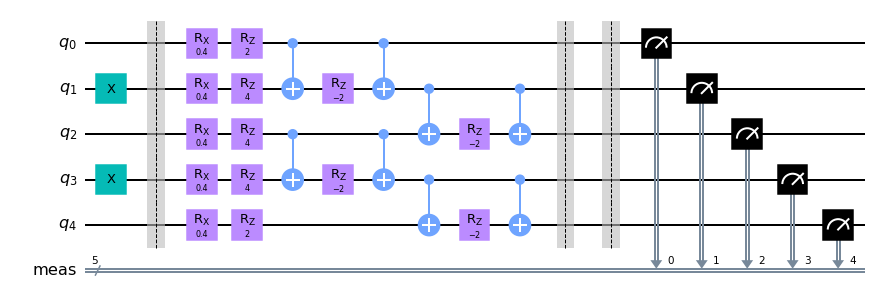

In [4]:
#See if the Trotter cirucit is correctly being built. Change x in Trotter_circuit[x] to see the cirucit
# for different time slices.
Trotter_circuit[1].draw(output='mpl')

In [5]:
#This cell sets up everything we need so the readout error mitigation will work.
from qiskit.test.mock import FakeVigo

backend = FakeVigo()

#This needs to be 5, since we have 5 qubits in our circuit.
qr = QuantumRegister(5)

noise_model = NoiseModel.from_backend(backend)

qubit_list = [0,1,2,3,4]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

qasm_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(meas_calibs, backend) #Aer.get_backend('qasm_simulator'))
qobj = assemble(t_qc, shots=10000)

#Note that the noise model isn't used until here. All the code in this cell above this comment is
# simply doing calibration of the circuit.
cal_results = qasm_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

meas_filter = meas_fitter.filter

In [6]:
from qiskit.test.mock import FakeVigo

ideal_backend = Aer.get_backend('qasm_simulator')

#Use a backend with an error model
backend = FakeVigo()

#Define the executor so mitiq will work. Note that the noise model is contained within here,
# so every time it is called, the result will be noisy.
def qiskit_multiqubit_executor(circuit, shots: 1000, qubit) -> float:
    """This function takes in a circuit, number of shots, and the qubit you are
    interested in, and returns <Z>, aka the expectation value of Z for the particular qubit that
    was input."""
#     noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(
#         depolarizing_error(one_qubit_error, 1),
#         ["u1", "u2", "u3"],
#     )
#     noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])
    
    noise_model = NoiseModel.from_backend(backend)
    
    basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        backend,
        basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    mit_results = meas_filter.apply(results)
    counts = mit_results.get_counts()
    prob = 0
    for x in counts.keys():
        if x[qubit] == '1':
            prob += counts[x] / shots
    return 2*prob - 1

In [7]:
#define the executor so mitiq will work. Note that the noise model is contained within here,
# so every time it is called, the result will be noisy.
def ideal_qiskit_multiqubit_executor(circuit, shots: 1000, qubit) -> float:
    """This function takes in a circuit, number of shots, and the qubit you are
    interested in, and returns <Z>, aka the expectation value of Z for the particular qubit that
    was input."""
#     noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(
#         depolarizing_error(one_qubit_error, 1),
#         ["u1", "u2", "u3"],
#     )
#     noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])
    
    #noise_model = NoiseModel.from_backend(backend)
    
    #basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        ideal_backend,
        #basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    mit_results = meas_filter.apply(results)
    counts = mit_results.get_counts()
    prob = 0
    for x in counts.keys():
        if x[qubit] == '1':
            prob += counts[x] / shots
    return 2*prob - 1

In [8]:
noise_result = qiskit_multiqubit_executor(Trotter_circuit[1],8192,0)
ideal_result = ideal_qiskit_multiqubit_executor(Trotter_circuit[1],8192,0)

print('With noise, the result is:', noise_result)
print('The ideal result is:', ideal_result)

With noise, the result is: -0.8956626858419394
The ideal result is: -0.9709651417405532


In [60]:
from functools import partial

#mitiq requires a particular formatting of the function, so functools partial is used to fit
# our function to that format.
partial_executor = partial(qiskit_multiqubit_executor, shots = 8192, qubit = 0)

mitiq.execute_with_zne(Trotter_circuit[1],partial_executor)

-0.8739295700648523

In [65]:
#This function is used to calculate the mitigated counts we will use to plot our data.
def zne_expval(input_shots, input_qubit, t):
    temp = partial(qiskit_multiqubit_executor, shots = input_shots, qubit = input_qubit)
    return mitiq.execute_with_zne(Trotter_circuit[t],temp, num_to_average = 3)

In [66]:
zne_expval(8192, 0, 1)

-0.8721461291360247

In [67]:
scale_factors = [1., 2., 3.]

linear_factory = mitiq.zne.inference.LinearFactory(scale_factors)

def zne_expval_linear_factory(input_shots, input_qubit, t):
    temp = partial(qiskit_multiqubit_executor, shots = input_shots, qubit = input_qubit)
    return mitiq.execute_with_zne(Trotter_circuit[t], temp, factory = linear_factory, num_to_average = 3)

# for x in range(1,20):
#     scale_factors = [x, x+1, x+2]
#     linear_factory = mitiq.zne.inference.LinearFactory(scale_factors)
#     result = zne_expval_linear_factory(8192,0,1)
#     if result < -1:
#         break
#     else:
#         print(result)

In [68]:
scale_factors = [1., 2., 3.]
linear_factory = mitiq.zne.inference.LinearFactory(scale_factors)

zne_expval_linear_factory(8192, 0, 1)

-0.9142934534924197

In [69]:
exp_factory = mitiq.zne.inference.ExpFactory(scale_factors)

def zne_expval_exp_factory(input_shots, input_qubit, t):
    temp = partial(qiskit_multiqubit_executor, shots = input_shots, qubit = input_qubit)
    return mitiq.execute_with_zne(Trotter_circuit[t], temp, factory = exp_factory, num_to_average = 3)

In [70]:
scale_factors = [1., 2., 3.]

#This does not converge

#zne_expval_exp_factory(8192, 0, 1)

In [71]:
poly_exp_factory = mitiq.zne.inference.PolyExpFactory(scale_factors, order = 1)

def zne_expval_poly_exp_factory(input_shots, input_qubit, t):
    temp = partial(qiskit_multiqubit_executor, shots = input_shots, qubit = input_qubit)
    return mitiq.execute_with_zne(Trotter_circuit[t], temp, factory = poly_exp_factory, num_to_average = 3)

In [72]:
#This does not converge

#zne_expval_poly_exp_factory(8192, 0, 1)

In [73]:
scale_factors = [1., 2., 3., 4., 5., 6.]

poly_factory = mitiq.zne.inference.PolyFactory(scale_factors, order = 3)

def zne_expval_poly_factory(input_shots, input_qubit, t):
    temp = partial(qiskit_multiqubit_executor, shots = input_shots, qubit = input_qubit)
    return mitiq.execute_with_zne(Trotter_circuit[t], temp, factory = poly_factory, num_to_average = 3)

In [74]:
zne_expval_poly_factory(8192, 0, 1)

-0.9279454612069794

In [75]:
def zne_expval_experiment(input_shots, input_qubit, t):
    temp = partial(qiskit_multiqubit_executor, shots = input_shots, qubit = input_qubit)
    return mitiq.execute_with_zne(Trotter_circuit[t], temp, num_to_average = 10)

In [76]:
zne_expval_experiment(8192, 0, 1)

-0.8968750441175207

In [77]:
ada_exp_factory = mitiq.zne.inference.AdaExpFactory(steps = 4)

def zne_expval_ada_exp_factory(input_shots, input_qubit, t):
    temp = partial(qiskit_multiqubit_executor, shots = input_shots, qubit = input_qubit)
    return mitiq.execute_with_zne(Trotter_circuit[t], temp, factory = ada_exp_factory, num_to_average = 3)

In [78]:
#zne_expval_ada_exp_factory(8192, 0, 1)

In [79]:
scale_factors = [1., 2., 3.]

vanilla_zne_list = []
linear_zne_list = []
poly_zne_list = []
#ada_exp_plot_list = []

for x in range(0,250):
    vanilla_zne_list.append(zne_expval(8192,0,1))
    linear_zne_list.append(zne_expval_linear_factory(8192,0,1))
    poly_zne_list.append(zne_expval_poly_factory(8192,0,1))
    #ada_exp_plot_list.append(zne_expval_ada_exp_factory(8192,0,1))

In [80]:
def is_abs_greater_than_1(x):
    if abs(x) > 1:
        return True
    else:
        return False

# for x, y, z in vanilla_zne_plot_list, linear_plot_list, poly_plot_list:
#     filtered_vanilla = filter(is_abs_greater_than_1, x)
#     filtered_linear = filter(is_abs_greater_than_1, y)
#     filtered_poly = filter(is_abs_greater_than_1, z)

filtered_vanilla_list = []
filtered_linear_list = []
filtered_poly_list = []

for x, y, z in zip(vanilla_zne_list, linear_zne_list, poly_zne_list):
    if abs(x) < 1:
        filtered_vanilla_list.append(x)
    if abs(y) < 1:
        filtered_linear_list.append(y)
    if abs(z) < 1:
        filtered_poly_list.append(z)

The mean of this data is: -0.9097317073269618 with a standard deviation of 0.0043601342429231225
The median of this data is: -0.9101975186269877
The average is 0.0612334344135913 from the ideal resultfrom the ideal result of -0.9709651417405532


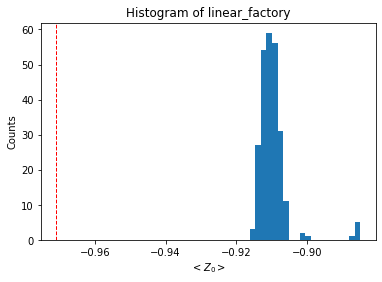

In [81]:
import statistics as stats

linear_average = stats.mean(filtered_linear_list)
linear_std = stats.stdev(filtered_linear_list)
linear_median = stats.median(filtered_linear_list)

plt.hist(filtered_linear_list,20)
plt.axvline(x=ideal_result, color='r', linestyle='dashed', linewidth=1)
plt.xlabel('$<Z_0>$')
plt.ylabel('Counts')
plt.title('Histogram of linear_factory')

print('The mean of this data is:', linear_average, 'with a standard deviation of', linear_std)
print('The median of this data is:', linear_median)
print('The average is', abs(ideal_result - linear_average), 
      'from the ideal result''from the ideal result of', ideal_result)

The mean of this data is: -0.9094937442861185 with a standard deviation of 0.019039147056416288
The median of this data is: -0.9114024823969935
The average is 0.06147139745443464 from the ideal result of -0.9709651417405532


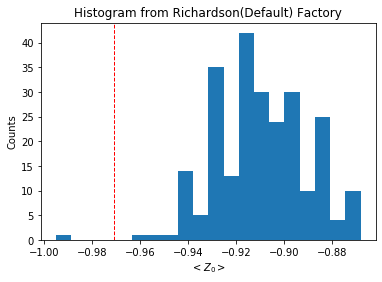

In [82]:
plt.hist(filtered_vanilla_list,20)
plt.xlabel('$<Z_0>$')
plt.ylabel('Counts')
plt.title('Histogram from Richardson(Default) Factory')

vanilla_average = stats.mean(filtered_vanilla_list)
vanilla_std = stats.stdev(filtered_vanilla_list)
vanilla_median = stats.median(filtered_vanilla_list)

plt.axvline(x=ideal_result, color='r', linestyle='dashed', linewidth=1)

print('The mean of this data is:', vanilla_average, 'with a standard deviation of', vanilla_std)
print('The median of this data is:', vanilla_median)
print('The average is', abs(ideal_result - vanilla_average), 'from the ideal result of', ideal_result)

The mean of this data is: -0.920172244285099 with a standard deviation of 0.021409215645099143
The median of this data is: -0.914601400943386
The average is 0.05079289745545412 from the ideal result of -0.9709651417405532


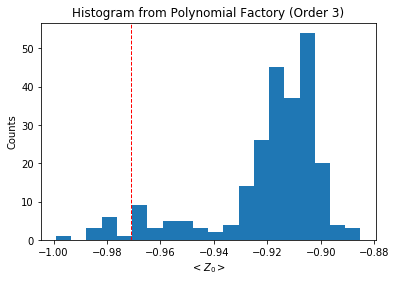

In [83]:
plt.hist(filtered_poly_list,20)
plt.xlabel('$<Z_0>$')
plt.ylabel('Counts')
plt.title('Histogram from Polynomial Factory (Order 3)')

poly_average = stats.mean(filtered_poly_list)
poly_std = stats.stdev(filtered_poly_list)
poly_median = stats.median(filtered_poly_list)

plt.axvline(x=ideal_result, color='r', linestyle='dashed', linewidth=1)

print('The mean of this data is:', poly_average, 'with a standard deviation of', poly_std)
print('The median of this data is:', poly_median)
print('The average is', abs(ideal_result - poly_average), 'from the ideal result of', ideal_result)

In [84]:
# plt.hist(ada_exp_plot_list,20)
# plt.xlabel('$<Z_0>$')
# plt.ylabel('Counts')
# plt.title('Histogram from Adaptive Exponential Factory')

# ada_exp_average = stats.mean(ada_exp_plot_list)
# ada_exp_std = stats.stdev(ada_exp_plot_list)
# ada_exp_median = stats.median(ada_exp_plot_list)

# plt.axvline(x=ideal_result, color='r', linestyle='dashed', linewidth=1)

# print('The mean of this data is:', ada_exp_average, 'with a standard deviation of', ada_exp_std)
# print('The median of this data is:', ada_exp_median)
# print('The average is', abs(ideal_result - ada_exp_average), 'from the ideal result of', ideal_result)

In [87]:
vanilla_std/linear_std

4.366642400361521

In [88]:
poly_std/linear_std

4.910219376811199